# Task 4.2: Explanation Analysis


In [2]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


# Set a seed for reproducibility
np.random.seed(42)



In [3]:
# Import the datasets

# Gun incidents data
df_incidents_cleaned = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64        

In [4]:
df_incidents_dt = df_incidents_cleaned.copy()
df_incidents_dt['isKilled'] = df_incidents_dt['n_killed'] > 0


In [5]:
coumns_not_to_drop_dt = ['isKilled', 'n_females',
                         'avg_age_participants', 
                         'density_incident_state', 'n_injured', 'n_arrested', 'latitude', 'longitude', 'povertyPercentage'] # ,

# broke all if you add n_killed since is higly correlated : 0.94

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                131618 non-null  float64
 1   longitude               131618 non-null  float64
 2   avg_age_participants    131618 non-null  int64  
 3   n_females               131618 non-null  int64  
 4   n_injured               131618 non-null  int64  
 5   n_arrested              131618 non-null  int64  
 6   povertyPercentage       131618 non-null  float64
 7   density_incident_state  131618 non-null  float64
 8   isKilled                131618 non-null  bool   
dtypes: bool(1), float64(4), int64(4)
memory usage: 9.2 MB


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_incidents_cleaned is your original DataFrame

UMBALANCE_DATA = False

if not UMBALANCE_DATA:

    # Select 100 samples where isKilled is True
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=5000, random_state=42)

    # Select 100 samples where isKilled is False
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=5000, random_state=42)
else:
    
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=500, random_state=42)
    
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=3000, random_state=42) 


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])

# Shuffle the rows in the new DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset



target = balanced_df['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt.info()

random_state = 42
test_size = 0.2
max_depth = 40
#X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)
train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)

# check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   latitude                10000 non-null  float64
 1   longitude               10000 non-null  float64
 2   avg_age_participants    10000 non-null  int64  
 3   n_females               10000 non-null  int64  
 4   n_injured               10000 non-null  int64  
 5   n_arrested              10000 non-null  int64  
 6   povertyPercentage       10000 non-null  float64
 7   density_incident_state  10000 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 625.1 KB


### 1.1 Lime on Decision Tree

In [7]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=60, min_samples_leaf=30)
dt = dt.fit(train_set, train_label)

In [8]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [9]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.788
Accuracy test set  0.753
Precision train set  0.7888333490521551
Recall train set  0.788
F1 score train set  0.7878469727225286
Support train set  (array([0.77331887, 0.80434783]), array([0.81485714, 0.76114286]), array([0.7935448 , 0.78214915]), array([3500, 3500]))


In [10]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [11]:
report_scores(test_label, test_pred_dt)


              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1500
           1       0.76      0.73      0.75      1500

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



In [12]:
import lime
import lime.lime_tabular
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Choose a sample from the test set for interpretation
sample_index = 0  # Replace with the index of the sample you want to interpret


# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not Killed', 'Killed'], discretize_continuous=True)

# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(test_set.iloc[sample_index].values , dt.predict_proba, num_features=len(train_set.columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)

/home/luca/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



## LIME on K-NN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize model
knn = KNeighborsClassifier(n_neighbors=4)

# Fit the model
knn.fit(train_set, train_label)

# Scegli un'istanza specifica dal set di test da spiegare
instance_to_explain = test_set.iloc[-1]

# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not KIlled', 'Killed'], discretize_continuous=True)

# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(instance_to_explain.values, knn.predict_proba, num_features=len(train_set.columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)


/home/luca/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



### 1.2 Lime on Neural Network

In [14]:
import tensorflow as tf
import numpy as np
#train_set, test_set, train_label, test_label

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
  tf.keras.layers.Dense(32, activation='relu'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

2023-12-31 17:06:45.603503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 17:06:45.611201: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 17:06:45.691482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 17:06:45.691559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 17:06:45.694025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [15]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
22/22 [==============================] - 2s 30ms/step - loss: 0.4735 - accuracy: 0.5086 - val_loss: 0.4432 - val_accuracy: 0.4886
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.3431 - accuracy: 0.5432 - val_loss: 0.3207 - val_accuracy: 0.5393
Epoch 3/30
22/22 [==============================] - 0s 15ms/step - loss: 0.2991 - accuracy: 0.5645 - val_loss: 0.2958 - val_accuracy: 0.5586
Epoch 4/30
22/22 [==============================] - 0s 12ms/step - loss: 0.2705 - accuracy: 0.5788 - val_loss: 0.2684 - val_accuracy: 0.5643
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2505 - accuracy: 0.5930 - val_loss: 0.2541 - val_accuracy: 0.5686
Epoch 6/30
22/22 [==============================] - 0s 10ms/step - loss: 0.2427 - accuracy: 0.6064 - val_loss: 0.2461 - val_accuracy: 0.5814
Epoch 7/30
22/22 [==============================] - 0s 9ms/step - loss: 0.2367 - accuracy: 0.6118 - val_loss: 0.2414 - val_accuracy: 0.5979
Epoch 8/30
22/

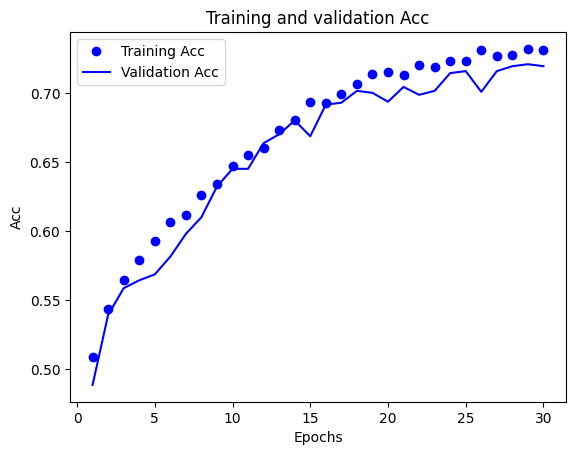

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [17]:
x_test = np.reshape(test_set.values, (len(test_set), 1, len(train_set.columns)))
test_pred_nn = (model.predict(x_test) > 0.6).astype("int32")

94/94 [==============================] - 1s 6ms/step


In [18]:
train_set.values

array([[ 3.20818000e+01, -8.38004000e+01,  5.00000000e+01, ...,
         0.00000000e+00,  1.68000000e+01,  4.13822365e-01],
       [ 3.70763000e+01, -9.46468000e+01,  3.80000000e+01, ...,
         2.00000000e+00,  1.08000000e+01,  8.55176315e-02],
       [ 3.25579000e+01, -8.39007000e+01,  4.30000000e+01, ...,
         0.00000000e+00,  1.47000000e+01,  4.13822365e-01],
       ...,
       [ 3.85218000e+01, -1.21428000e+02,  1.50000000e+01, ...,
         0.00000000e+00,  1.14000000e+01,  6.39967943e-01],
       [ 4.38524000e+01, -8.50236000e+01,  3.70000000e+01, ...,
         0.00000000e+00,  1.22000000e+01,  2.70978691e-01],
       [ 4.30404000e+01, -7.61448000e+01,  2.50000000e+01, ...,
         0.00000000e+00,  1.21000000e+01,  5.34650198e-01]])

In [19]:
# Scegli un'istanza specifica dal set di test da spiegare
instance_to_explain = test_set.iloc[-1]

# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not KIlled', 'Killed'], discretize_continuous=True)

# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(instance_to_explain.values, model.predict, num_features=len(train_set.columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)


157/157 [==============================] - 1s 4ms/step


/home/luca/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning:


                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    



## NN with Shap

In [20]:
import tensorflow as tf
import numpy as np
#train_set, test_set, train_label, test_label

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])



model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [21]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
22/22 [==============================] - 1s 25ms/step - loss: 0.2452 - accuracy: 0.5602 - val_loss: 0.2438 - val_accuracy: 0.5629
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2430 - accuracy: 0.5663 - val_loss: 0.2430 - val_accuracy: 0.5650
Epoch 3/30
22/22 [==============================] - 0s 13ms/step - loss: 0.2416 - accuracy: 0.5782 - val_loss: 0.2420 - val_accuracy: 0.5629
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2408 - accuracy: 0.5814 - val_loss: 0.2417 - val_accuracy: 0.5643
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2400 - accuracy: 0.5898 - val_loss: 0.2413 - val_accuracy: 0.5707
Epoch 6/30
22/22 [==============================] - 0s 10ms/step - loss: 0.2394 - accuracy: 0.5864 - val_loss: 0.2414 - val_accuracy: 0.5664
Epoch 7/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2389 - accuracy: 0.5932 - val_loss: 0.2407 - val_accuracy: 0.5679
Epoch 8/30
22

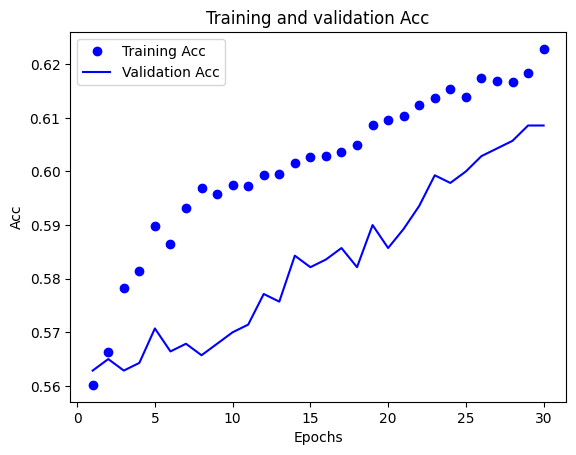

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [23]:
x_test = np.reshape(test_set.values, (len(test_set), 1, len(train_set.columns)))
test_pred_nn = (model.predict(x_test) > 0.6).astype("int32")

94/94 [==============================] - 0s 4ms/step


In [24]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

           0       0.55      0.84      0.66      1500
           1       0.66      0.31      0.42      1500

    accuracy                           0.57      3000
   macro avg       0.61      0.57      0.54      3000
weighted avg       0.61      0.57      0.54      3000



### SHAP Evaluation

## Shap on SVM

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm

#train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)

#x_train_reshaped = train_set.reshape(train_set.shape[0], -1)


svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(train_set, train_label)



In [ ]:
def print_svm_scores(svm_classifier):
    print("Accuracy on training set: {:.3f}".format(svm_classifier.score(train_set, train_label)))
    print("Accuracy on test set: {:.3f}".format(svm_classifier.score(test_set, test_label)))
    
    # Make predictions
    y_pred = svm_classifier.predict(test_set)

    # Evaluate the model
    accuracy = accuracy_score(test_label, y_pred)
    report = classification_report(test_label, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

In [ ]:
print_svm_scores(svm_classifier)

Accuracy on training set: 0.714
Accuracy on test set: 0.719
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.61      0.69      1500
        True       0.68      0.82      0.75      1500

    accuracy                           0.72      3000
   macro avg       0.73      0.72      0.72      3000
weighted avg       0.73      0.72      0.72      3000



Using 7000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

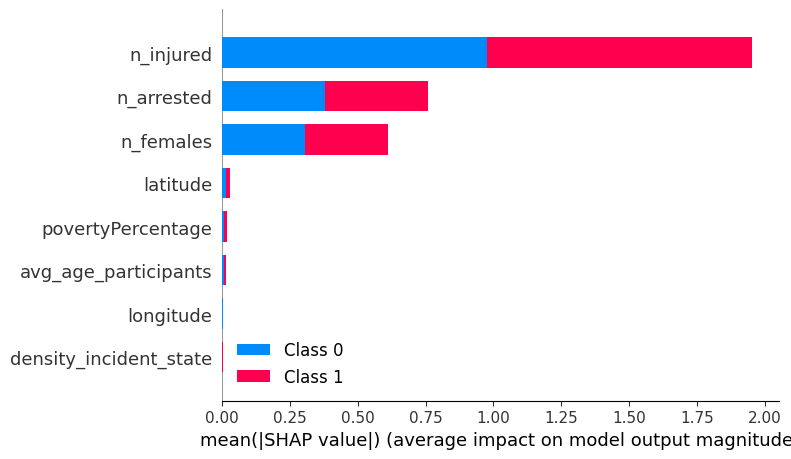

In [ ]:
import shap

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm_classifier.predict_proba, train_set, link="logit")
n = 2
shap_values = explainer.shap_values(test_set[0:n])

shap.summary_plot(shap_values, test_set[0:n])


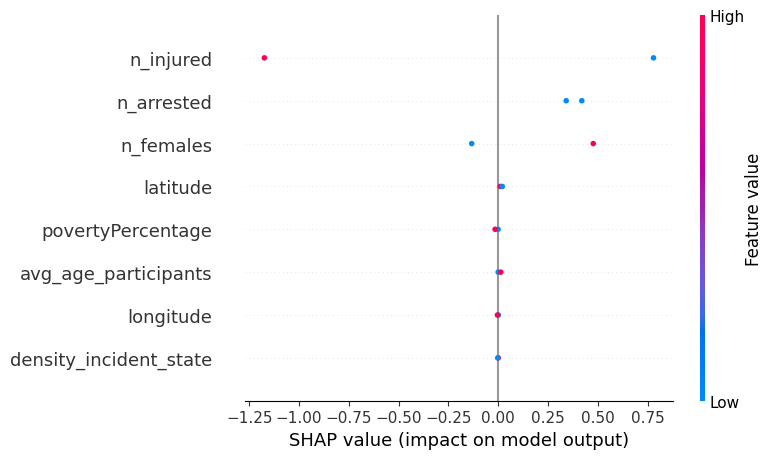

In [ ]:
shap.summary_plot(shap_values[1], test_set.iloc[0:n])

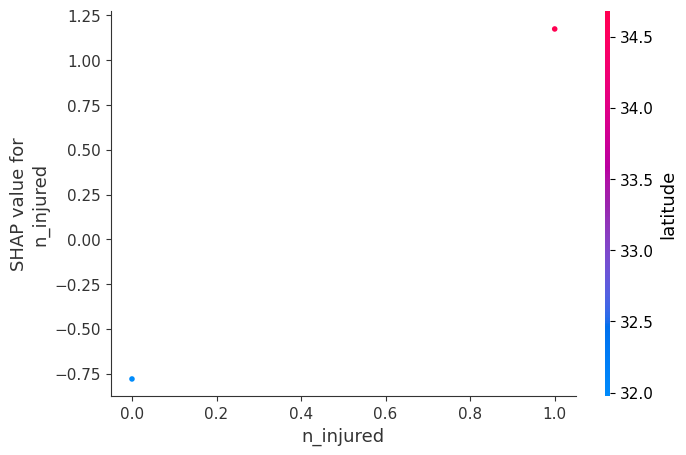

In [ ]:
shap.dependence_plot("n_injured", shap_values[0], test_set[0:n])

In [ ]:

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0:], test_set[0:n])

## SHAP on KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize model
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the model
knn.fit(train_set, train_label)

# Get the model explainer object
explainer = shap.KernelExplainer(knn.predict_proba, train_set)

# Get shap values for the test data observation whose index is 0, i.e. first observation in the test set

n = 20
shap_values = explainer.shap_values(test_set[0:n])
# Generate a force plot for this first observation using the derived shap values
shap.force_plot(explainer.expected_value[0], shap_values[0][0:], test_set[0:n])

NameError: name 'train_set' is not defined